# 0. File Set up

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
from plott import plott

%matplotlib inline

In [2]:
# Define standard fontsize
small_font = 10
axis_label_font = 10
medium_font = 12
title_font = 16

# Define the d13C contour characterisics
cmap = 'rainbow'
d13C_color_min = -1.0
d13C_color_max = 2.0
d13C_color_levels = np.arange(d13C_color_min, d13C_color_max, (d13C_color_max-(d13C_color_min))/50)

# Import standardised latitudes and depths
lat_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')


In [3]:
# Define function for standardising axes

def d13C_axes_correction(fig, ax, output, label = '', yax_label = '', xax_label = '', legend = False):
    
    # Add legend
    if legend == True:
        divider = make_axes_locatable(ax)
        colorbar_ax = divider.append_axes("right",size="5%",pad=0.05)
        colorbar_ax = fig.colorbar(output, cax = colorbar_ax)
        colorbar_ax.set_label(u'$\delta^{13}$C (\u2030)', fontsize = axis_label_font)
        colorbar_ax.ax.tick_params(labelsize=axis_label_font)

    # Add optional labels to subplot
    ax.text(60, 4500, label, fontsize = medium_font)
    ax.set_ylabel(yax_label)
    ax.set_xlabel(xax_label)
    
    # Flip plot
    ax.invert_yaxis()
    
    # Define out of bounds colour
    output.cmap.set_under('k')
    output.cmap.set_over('k')

    # Define plot limits
    depth_min = 0
    depth_max = 5000
    lat_min = -90
    lat_max = 90

    # Apply limits
    ax.set_ylim(depth_max, depth_min)
    ax.set_xlim(lat_min, lat_max)
    
    # Correct font sizes in axes
    for item in ([ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(small_font) 
    
    return(ax, output)
    

In [4]:
####3 reading data function

def read_data(folder):

    # Import simulation details (summary) as dataframe
    summary = pd.read_csv(folder + '_summary.txt', delimiter = ' ')

    # Import simulation outputs
    fh = Dataset(folder + 'output.nc')
    proxy_simulations = fh.variables['var1_1'][:] 

    # Import samples (proxy data)
    samples = pd.read_csv( folder + '_samples.txt', delimiter = ' ')

    # Drop all unnecessary rows in summary
    summary = summary.drop(['type', 'Row.names', 'reps', 'model', 'dataset', 'filename', 'success.rate'], axis = 1)

    # Convert run.no to netcdf file index
    summary['run.no'] = summary['run.no'] - 1
    samples['run.no'] = samples['run.no'] - 1
    
    return(proxy_simulations, samples, summary)

In [102]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > float(minn)]
    df = df[df['age'].astype(float) < float(maxx)]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > float(minn)]
    df2 = df2[df2['age'].astype(float) < float(maxx)]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [103]:

### Redo the age model for the peterson dataset

years = pd.read_csv('../Moving_water_mass/Data/year_range.txt', delimiter = ' ')

# Age range to look over
minn = 110
maxx = 140

names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

# Read in the data
indopac = pd.read_table("../Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
atl = pd.read_table("../Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
add = pd.read_table("../Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

# Join all into a single dataframe
df = indopac.append(atl)
df = atl.append(add)
df = df.reset_index(drop = True)

df['d18O names'] = df['Core'] + '_ageLS16.txt'
df['d13C names'] = df['Core'] + '_d13C.txt'

# Loop over the dataset and interpolate each core
i = 0
results_dict = {}

while i < df.count()[0]:

    try:
        df_d18O = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
    except:
        i += 1
        continue
    try:
        df_d13C = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
    except:
        i += 1
        continue

    df_d18O = df_d18O.dropna(subset = ['age']) 
    df_d13C = df_d13C.dropna(subset = ['d13C'])

    df_d18O = df_d18O.reset_index(drop = True)
    df_d13C = df_d13C.reset_index(drop = True)

    interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
    try:
        df_d13C['age'] = interp(df_d13C['depth'])
    except:
        try:
            interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
            df_d13C['age'] = interp2(df_d13C['depth'])
        except:
            i += 1
            continue

    df_d13C = df_d13C.dropna(subset = ['age'])
    df_d13C = df_d13C.reset_index(drop = True)

    df_d13C = df_d13C[df_d13C['age'] > minn]
    df_d13C = df_d13C[df_d13C['age'] < maxx]

    if len(df_d13C) > 0:
        df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
        df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

        df_d13C = df_d13C.drop(['depth'], axis = 1)

        df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
        results_dict.update({
            df_results.Core[0] : df_results.drop(['Core'], axis = 1)
        })
    
    i += 1

# ################## read in the oliver data using the predefined function

df_oliver = Oliver_cores(minn,maxx)

###################3 join the dataframes

df_results = pd.concat(results_dict).reset_index()
df_results = df_results.rename(columns = {'level_0' : 'Core'})
df_results = df_results.drop(['level_1'], axis = 1)
df_results = df_results.append(df_oliver)
  
#################### get only the atlantic cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df_atl = df[df['Location'] == 'Atlantic']
df_atl = df_atl.reset_index(drop = True)
df_atl['age'] = df_atl.age.astype(float)

# 1. Error & variability evaluation of jackknifing

#### Use jackknifing to evaluate what the impact is of specific proxies on the end model results, by looking at the:
- The variation in sigma (error) of the stat model
- Variation in the mean d13C, depth of the middle values between the north and south end-members
- The average deviation of the stat model from the original proxy (mean model residual)

In [105]:
# Read data
proxy_simulations, samples, summary = read_data(
    '/srv/ccrc/data06/z5145948/Moving_water_mass/Output_condensed/Jackknifing_original_boundaries/'
)

In [106]:
print('\033[1m' + "Summary of the model simulations:")
summary

Summary of the model simulations:


,equation,period,run.no,dep_4,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
0,tanh,Holocene,0,NaN,0.396913,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.806515,0.231712,-6.036957e-05,-2.284588e+02,127,129
1,tanh,Holocene,1,NaN,0.398309,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.076636,0.350119,-9.764133e-05,-2.993166e+02,127,129
2,tanh,Holocene,2,NaN,1.005573,0.507143,-0.04625,NaN,NaN,NaN,NaN,254.689939,-35.728595,9.011617e-03,4.006885e+04,127,129
3,tanh,Holocene,3,NaN,0.376023,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.030311,-0.005257,9.216163e-07,4.529428e+00,127,129
4,tanh,Holocene,4,NaN,0.385154,0.507143,-0.04625,NaN,NaN,NaN,NaN,-8.358599,1.161368,-2.930102e-04,-1.304750e+03,127,129
5,tanh,Holocene,5,NaN,0.377281,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.029831,-0.005682,9.921044e-07,4.989904e+00,127,129
6,tanh,Holocene,6,NaN,0.374985,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.030098,-0.005411,9.470386e-07,4.698286e+00,127,129
7,tanh,Holocene,7,NaN,0.393744,0.507143,-0.04625,NaN,NaN,NaN,NaN,0.185137,1.317031,-3.712446e-04,-1.102729e+03,127,129
8,tanh,Holocene,8,NaN,0.437228,0.507143,-0.04625,NaN,NaN,NaN,NaN,-37.414754,0.971942,-1.317116e-04,-2.258913e+03,127,129
9,tanh,Holocene,9,NaN,0.368586,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.030163,-0.005433,9.509508e-07,4.718865e+00,127,129


In [107]:
# Define the latitudes for the d13C slice (20N - 30N)

d13Cmaxdepth_latmin = np.abs(lat_standardised - (20)).argmin()
d13Cmaxdepth_latmax = np.abs(lat_standardised - (30)).argmin()
lat_maxdepth_slice = lat_standardised[d13Cmaxdepth_latmin : d13Cmaxdepth_latmax]

# Reduce the models and the proxy depth axis to include the shallower region

dep_min = np.abs(dep_standardised - (800)).argmin()

dep_standardised = dep_standardised[dep_min:]

proxy_simulations_regrid_LIG = np.array([x[dep_min : , :] for x in proxy_simulations])

######## Find the middle value between the end members

# Northern EM boundaries

N_EM_latmin = np.abs(lat_standardised - (50)).argmin()
N_EM_latmax = np.abs(lat_standardised - (70)).argmin()
N_EM_depmin = np.abs(dep_standardised - (1000)).argmin()
N_EM_depmax = np.abs(dep_standardised - (3000)).argmin()

# Southern EM boundaries

S_EM_latmin = np.abs(lat_standardised - (-60)).argmin()
S_EM_latmax = np.abs(lat_standardised - (-40)).argmin()
S_EM_depmin = np.abs(dep_standardised - (1000)).argmin()
S_EM_depmax = np.abs(dep_standardised - (5000)).argmin()

In [8]:
# Depth of the middle values between the north and south end-memers

#############Need to update so that it is not on the UVic grid--cannot see variations currently##########

for run in np.unique(summary['run.no']):

    # Get 127kaBP proxy model results
    proxy_127ka_d13C = np.squeeze(proxy_simulations[run,:,:])

    # Get the proxy used for the model
    samples_127ka = samples[samples['run.no'] == run]

    ### Find middle value

    proxy_N_EM = np.nanmean(proxy_simulations_regrid_LIG.T[N_EM_latmin : N_EM_latmax, N_EM_depmin : N_EM_depmax])
    proxy_S_EM = np.nanmean(proxy_simulations_regrid_LIG.T[S_EM_latmin : S_EM_latmax, S_EM_depmin : S_EM_depmax])
    proxy_d13C_middle_value = np.mean([proxy_N_EM, proxy_S_EM])

    # Get the middle d13C depth

    proxy_oneD_depth_slice = np.nanmean(proxy_simulations[3][:, d13Cmaxdepth_latmin : d13Cmaxdepth_latmax], axis = 1)
    proxy_oneD_depth_slice[np.isnan(proxy_oneD_depth_slice)] = -1000
    proxy_middle_depth = dep_standardised[np.abs(proxy_oneD_depth_slice - proxy_d13C_middle_value).argmin()]

    print((proxy_middle_depth))


1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0
1650.0


/home/z5145948/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


In [109]:
######## Jackknifing model results

# get the index of proxy samples on the lat-dep grid

samples['Location_indeces'] = [[np.abs(dep_standardised - (x)).argmin(),
                                 np.abs(lat_standardised - (y)).argmin()] for x, y in zip(samples['Ocean_depth'],
                                                                                          samples['Lat'])]
# For each run number, get the model d13C value that corresponds to the proxy location using indecies
for run in np.unique(samples['run.no']):
    samples.loc[samples['run.no'] == run, 'Model_results'] = [
        proxy_simulations_regrid_LIG[run, x[0], x[1]] for x in samples[samples['run.no'] == run]['Location_indeces']
    ]

# Find the deviation of the model results from the proxy value
samples['Deviation'] = np.abs(samples['d13C'] - samples['Model_results'])

# Get the stat model results for each run into a single df
samples = samples[pd.notnull(samples['Model_results'])]
stat_model_results = samples.groupby('run.no').mean()
stat_model_results = stat_model_results.drop(['Lat', 'Lon', 'Ocean_depth', 'count'], axis=1)

In [110]:
## Find which proxy point was bootstrapped on each run

# get all the proxy locations
completed_locations = samples[['Lat', 'Lon', 'Ocean_depth']].drop_duplicates().reset_index(drop = True)

# Loop over each run
proxy_jackknifed = {}

for run in np.unique(samples['run.no']):
    
    # Get all the samples in a single run
    samples_one_run = samples[samples['run.no'] == run]
    samples_one_run = samples_one_run[['Lat', 'Lon', 'Ocean_depth']].drop_duplicates().reset_index(drop = True)
    
    # find out which proxy is missing in samples_one_run compared to the completed_locations
    df_merged = pd.merge(samples_one_run, completed_locations, how='outer', indicator=True)
    df_merged = df_merged[df_merged['_merge'] == 'right_only']
    df_merged['run.no'] = run
    
    # add the missing proxy to the dictionary
    proxy_jackknifed.update({
        run : df_merged
    })
    
#     

proxy_jackknifed = pd.concat(proxy_jackknifed, axis=0)
proxy_jackknifed = proxy_jackknifed.reset_index(drop=True)
proxy_jackknifed.index = proxy_jackknifed['run.no']
proxy_jackknifed = proxy_jackknifed.drop(['_merge', 'run.no'], axis=1)

In [112]:
# Merge the model results with the bootstrapped proxy details, remove NaN rows, and get core names to add
proxy_bootstrapped_impact = pd.concat([stat_model_results, proxy_jackknifed], axis=1)
proxy_bootstrapped_impact = proxy_bootstrapped_impact.dropna()
proxy_bootstrapped_impact

,d13C,stdev,Model_results,Deviation,Lat,Lon,Ocean_depth
run.no,,,,,,,
0,0.481226,0.205242,0.433186,0.341866,5.91,-44.2000,4056.0
1,0.494226,0.205242,0.351394,0.432849,-3.48,-7.6000,4033.0
2,0.491893,0.205242,0.101321,0.558000,1.66,-10.9800,4588.0
3,0.495226,0.205242,0.458621,0.329938,-5.78,-10.7500,3125.0
4,0.516893,0.205242,0.433357,0.345552,-3.56,-16.4300,4675.0
5,0.504893,0.205242,0.459988,0.332193,-23.43,11.7000,2987.0
6,0.493893,0.205242,0.459152,0.328519,30.63,-12.4000,2324.0
7,0.494448,0.226507,0.359584,0.432690,25.17,-16.8500,2573.0
8,0.489893,0.205242,0.396464,0.362778,5.67,-19.8500,2862.0


In [135]:
for i in proxy_bootstrapped_impact.index:
    print(i)
    print(
        list(df_atl[(df_atl.Lat == list(proxy_bootstrapped_impact['Lat'])[i]) & (df_atl.Lon == list(proxy_bootstrapped_impact['Lon'])[i])]['Core'])[0]
    )
    #print(proxy_bootstrapped_impact.loc[[i]])


0
EW9209-1JPC
1
GeoB1041
2
GeoB1101
3
GeoB1112
4
GeoB1118
5
GeoB1710
6
GeoB4216
7
GIK12392-1
8
GIK13519-1
10
GIK23414-9
11
GIK23415-9
12
IODP-U1308
14
ODP983
16
PS2498
18
SU90-03
19
SU90-11
20
V29-202
21
CH69_K09
22
GEOB1028-5
23
GEOB2109-1
25
GEOB4403-2
26
GIK16772-1
27


IndexError: list index out of range

In [142]:
i = 26
df_atl[(df_atl.Lat == proxy_bootstrapped_impact['Lat'].loc[[i]]) & (df_atl.Lon == proxy_bootstrapped_impact['Lon'].loc[[i]])]['Core']


ValueError: Can only compare identically-labeled Series objects

In [141]:
i = 27
proxy_bootstrapped_impact['Lat'].loc[[i]]

run.no
27   -20.1
Name: Lat, dtype: float64

In [55]:
samples_one_run = samples[samples['run.no'] == 2]
samples_one_run = samples_one_run[['Lat', 'Lon', 'Ocean_depth']].drop_duplicates().reset_index(drop = True)
df_merged = pd.merge(samples_one_run, completed_locations, how='outer', indicator=True)
df_merged = df_merged[df_merged['_merge'] == 'right_only']

# Remove any runs where the proxy that was removed was not in any of the modelled areas
# These make no difference to the jackknifing
if df_merged.empty:
    samples = samples[~(samples['run.no'] == run)]
    continue

SyntaxError: 'continue' not properly in loop (<ipython-input-55-5efd72e121cc>, line 10)

,equation,period,run.no,dep_4,sigma,N_mem,A_mem,a.AABW,b.AABW,c.AABW,e.AABW,a.NADW,b.NADW,c.NADW,e.NADW,lower,upper
0,tanh,Holocene,0,NaN,0.391164,0.507143,-0.04625,NaN,NaN,NaN,NaN,-2.295370,0.303650,-7.654955e-05,-344.714695,127,129
1,tanh,Holocene,1,NaN,0.390487,0.507143,-0.04625,NaN,NaN,NaN,NaN,0.003927,0.790587,-2.225958e-04,-665.602180,127,129
2,tanh,Holocene,2,NaN,0.390289,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.134626,0.032968,-8.990513e-06,-32.517512,127,129
3,tanh,Holocene,3,NaN,0.405783,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.758852,0.649799,-1.769220e-04,-582.256734,127,129
4,tanh,Holocene,4,NaN,0.390024,0.507143,-0.04625,NaN,NaN,NaN,NaN,-1.062388,0.139295,-3.526020e-05,-158.158718,127,129
5,tanh,Holocene,5,NaN,0.368552,0.507143,-0.04625,NaN,NaN,NaN,NaN,-0.616652,-0.007094,2.078083e-06,-13.570376,127,129
6,tanh,Holocene,6,NaN,0.997396,0.507143,-0.04625,NaN,NaN,NaN,NaN,0.294099,-0.046643,1.160783e-05,51.400266,127,129
7,tanh,Holocene,7,NaN,0.390476,0.507143,-0.04625,NaN,NaN,NaN,NaN,0.146275,0.971804,-2.744861e-04,-812.045316,127,129
8,tanh,Holocene,8,NaN,1.003913,0.507143,-0.04625,NaN,NaN,NaN,NaN,3.825397,-0.478134,1.200967e-04,549.762485,127,129
9,tanh,Holocene,9,NaN,0.404911,0.507143,-0.04625,NaN,NaN,NaN,NaN,-1408.731083,196.643877,-4.957435e-02,-220796.000356,127,129


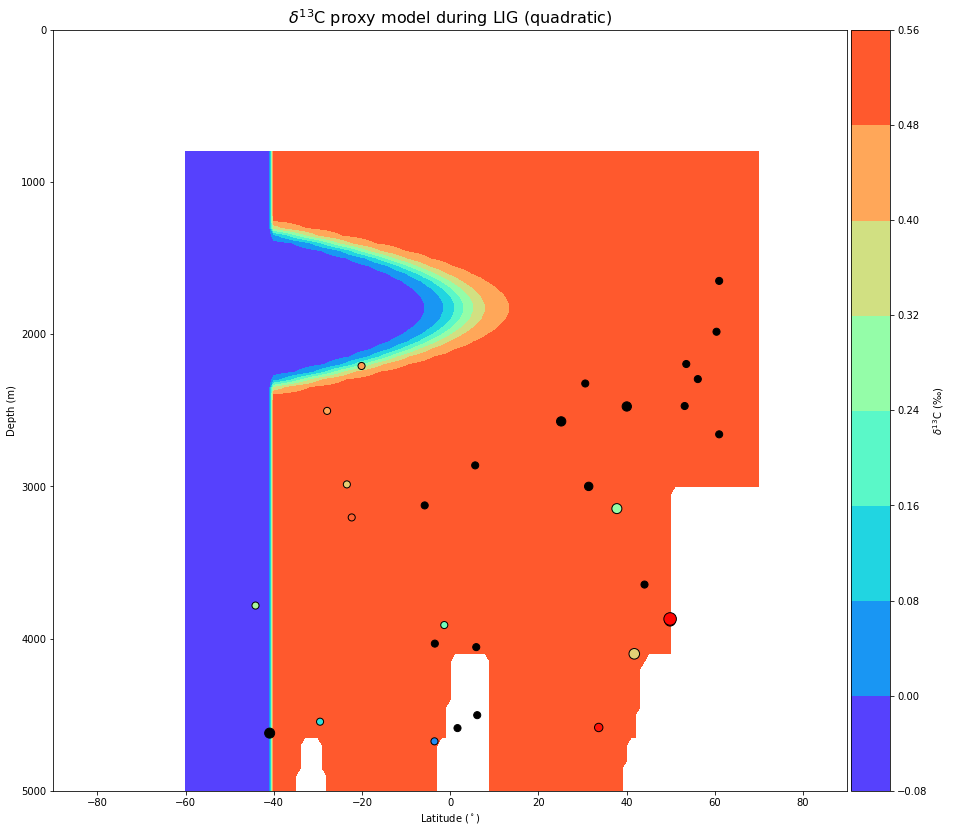

In [73]:
# Set up plots

run = 4

samples_127ka_tanh = samples[samples['run.no'] == run]
proxy_tanh = proxy_simulations[run]
dep_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')
d13C_color_min = -0.1
d13C_color_max = 0.6

fig3 = plt.figure(figsize=(15, 14))
ax1 = plt.subplot2grid((1,1),(0,0))

# Plot the proxy models
d13C_output_proxy_quad = ax1.contourf(lat_standardised,
                      dep_standardised,
                      proxy_tanh,
                      cmap = cmap,
                      vmin = d13C_color_min,
                      vmax = d13C_color_max,
                      extent = 'both')
ax1.set_title('$\delta^{13}$C proxy model during LIG (quadratic)', fontsize = title_font)


# Plot the original proxy values

for scatters, ax in zip([samples_127ka_tanh], [ax1]):
    ax.scatter(scatters['Lat'],
                scatters['Ocean_depth'],
                c = scatters['d13C'],
                cmap = cmap,
                s = 50*(scatters['count']**0.5),
                vmin = d13C_color_min,
                vmax = d13C_color_max,
                edgecolor = 'k')

# Correct the axes
ax1, d13C_output_proxy_quad = d13C_axes_correction(fig3,
                                   ax1,
                                   d13C_output_proxy_quad,
                                   yax_label = 'Depth (m)',
                                   xax_label = 'Latitude ($^\circ$)',
                                   legend = True)


print('')

In [63]:
proxy_tanh.shape

(120, 160)

In [64]:
lat_standardised.shape

(160,)

In [65]:
dep_standardised.shape

(104,)